In [8]:
import pandas as pd 
import numpy as np
import math
# pd.set_option("display.max_rows", 100)

import matplotlib.pylab as pylt
pylt.rcParams['figure.dpi'] = 200
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [9]:
data = pd.read_csv('data/cleaned.csv')
# ['End Date', 'Pollster', 'Scope', 'Sample', 'ALP 2pp', 'L-NP 2pp', 'ALP rolling', 'LNP rolling']

### Creating a named tuple for clarity
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])


In [10]:
### Functions

def get_error(poll, sample_size):
    ### function to get sample error
    zee = 1.96
    poll = poll/100

    error = (zee * math.sqrt(((poll * (1- poll))/sample_size))) * 100

    return error

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    ### Update function
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    ### Predict the next from prior
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

<Axes: xlabel='End Date', ylabel='KF'>

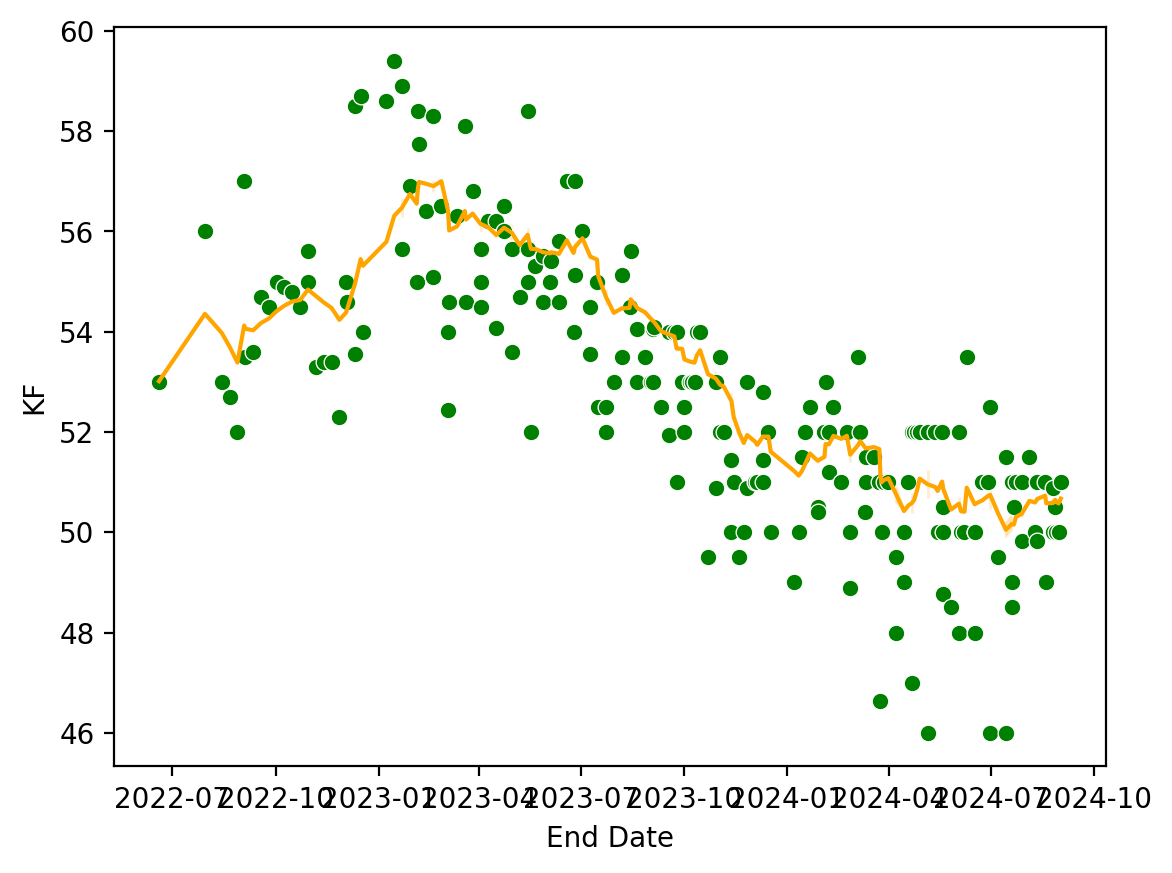

In [11]:
df = data.loc[data['Scope'] == 'National'].copy()
df['End Date'] = pd.to_datetime(df['End Date'])
df.sort_values(by=['End Date'], ascending=True, inplace=True)


### Make sure things are numbers
for col in ['ALP 2pp','Sample']:
    df[col] = pd.to_numeric(df[col])


def filter(frame, poll_col, sample_col):

    interno = frame.copy()

    first_poll = frame.iloc[0][poll_col]

    all_polls = frame[poll_col].tolist()

    ### This is something we need to ask Luke about - right now we aren't really doing anything with the process 
    # how much should/are we weighting towards measurements vs predictions? Can we infer this? 
    # should we be adjusting for measurement error/house effects?

    process_model = gaussian(0.05, 0.05) 
    # print("process_var: ", process_var)

    x = gaussian(first_poll, np.var(all_polls))

    xs = []

    ### THis is looping through all the rows in the dataframe, 
    # using the poll column as Z value and sample column to calculate errors
    
    for index,row in interno.iterrows():

        prior = predict(x, process_model)

        likelihood = gaussian(row[poll_col], get_error(row[poll_col], row[sample_col]))

        x = update(prior, likelihood)

        xs.append(x.mean)

    interno['KF'] = pd.Series(xs)
    
    return interno




outty = filter(df, 'ALP 2pp','Sample')

outty['End Date'] = pd.to_datetime(outty['End Date'])


sns.lineplot(outty, x='End Date', y='KF', color='orange')
sns.scatterplot(outty, x='End Date', y='ALP 2pp', color='g')
